## example

In [1]:
import cv2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import os
import ast

In [2]:
import seaborn as sns

In [3]:
from scipy.stats import gaussian_kde

In [27]:
map_image = cv2.imread(r"ref_image\cam\book_fair_2019.png")

In [5]:
with open("H_cam2map.json", "r") as f:
    transform = json.load(f)

H = np.array(transform["match_front_room"])
H

array([[ 0.95499152,  1.44536406,  0.05376705],
       [-0.02739988,  1.65504677,  0.10712096],
       [-0.07299328,  2.60997656,  1.        ]])

In [6]:
# โหลด CSV detections
df = pd.read_csv(r"detections_log_front_room_2.csv")

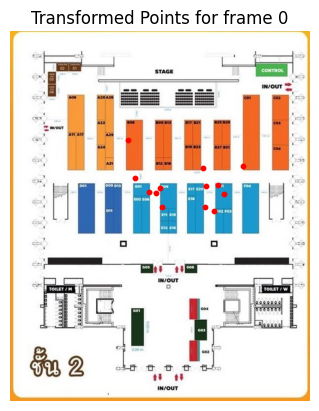

In [7]:
# เลือก frame_id ที่ต้องการ
frame_id = 0
frame_df = df[df["frame_id"] == frame_id]

# เตรียม list สำหรับเก็บจุดที่แปลงแล้ว
transformed_points = []

for i, row in frame_df.iterrows():
    xy_str = row["person_xy"]  # เช่น "[0.4189, 0.8903]"
    try:
        xy = eval(xy_str)  # แปลง string → list [x, y]
    except:
        continue  # ถ้า format ไม่ถูกข้าม

    # สร้างจุดในรูปแบบ homogeneous (x, y, 1)
    example_point = np.array([xy[0], xy[1], 1])

    # คูณกับ H matrix
    output_point = H @ example_point

    # Normalize กลับมาเป็น (x, y)
    transformed_point = output_point[:2] / output_point[2]
    transformed_points.append(transformed_point)

# Plot จุดทั้งหมดบน map
plt.imshow(cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB))

map_h, map_w = map_image.shape[:2]
for pt in transformed_points:
    plt.scatter(pt[0] * map_w, pt[1] * map_h, color='red', s=10)

plt.title(f"Transformed Points for frame {frame_id}")
plt.axis("off")
plt.show()

## fill_missing

In [8]:
# แปลง string list ให้เป็น list จริง ๆ (ใช้ ast.literal_eval ปลอดภัยกว่า eval)
df['person_box'] = df['person_box'].apply(ast.literal_eval)
df['person_xy'] = df['person_xy'].apply(ast.literal_eval)

# เตรียมเก็บแถวทั้งหมดและแถวที่เติม
all_rows = []
added_rows = []

# เก็บข้อมูลล่าสุดของแต่ละ person_id
last_data_per_person = {}
last_frame_per_person = {}

for idx, row in df.iterrows():
    frame_id = row["frame_id"]
    person_id = row["person_id"]

    if person_id in last_data_per_person:
        gap = frame_id - last_frame_per_person[person_id]
        if gap > 1 and gap <= 30:
            # เติมข้อมูล frame ที่หายไปโดยการ interpolate ค่า
            for f in range(last_frame_per_person[person_id] + 1, frame_id):
                ratio = (f - last_frame_per_person[person_id]) / gap
                interp_box = [
                    round(last_data_per_person[person_id]['person_box'][i] * (1 - ratio) + row['person_box'][i] * ratio, 4)
                    for i in range(4)
                ]
                interp_xy = [
                    round(last_data_per_person[person_id]['person_xy'][i] * (1 - ratio) + row['person_xy'][i] * ratio, 4)
                    for i in range(2)
                ]
                added_row = {
                    "frame_id": f,
                    "timestamp": None,
                    "video_time_sec": None,
                    "person_id": person_id,
                    "person_box": interp_box,
                    "person_xy": interp_xy
                }
                added_rows.append(added_row)  # เก็บแถวเติมแยก
                all_rows.append(added_row)

    # เพิ่มแถวเดิม
    all_rows.append(row.to_dict())

    # อัพเดตข้อมูลล่าสุดของคนนี้
    last_data_per_person[person_id] = row
    last_frame_per_person[person_id] = frame_id

# สร้าง DataFrame ใหม่จากแถวทั้งหมด
df_interp = pd.DataFrame(all_rows)
df_interp = df_interp.sort_values(["frame_id", "person_id"]).reset_index(drop=True)

# DataFrame เฉพาะแถวเติม (interpolated rows)
df_added_only = pd.DataFrame(added_rows)
df_added_only = df_added_only.sort_values(["frame_id", "person_id"]).reset_index(drop=True)


In [9]:

df_added_only.head()


,frame_id,timestamp,video_time_sec,person_id,person_box,person_xy
0,36,None,None,20,"[0.2307, 0.3243, 0.2797, 0.5526]","[0.2552, 0.4385]"
1,37,None,None,20,"[0.2328, 0.326, 0.2808, 0.5492]","[0.2568, 0.4376]"
2,38,None,None,20,"[0.2349, 0.3278, 0.2819, 0.5457]","[0.2584, 0.4368]"
3,39,None,None,20,"[0.237, 0.3296, 0.283, 0.5423]","[0.26, 0.436]"
4,40,None,None,20,"[0.2391, 0.3313, 0.2841, 0.5389]","[0.2616, 0.4351]"


In [10]:
# เติม video_time_sec จาก frame_id เดียวกันที่ค่าไม่ว่าง
df_interp['video_time_sec'] = df_interp.groupby('frame_id')['video_time_sec'] \
                         .transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [11]:
df_interp[df_interp.isnull().any(axis=1)].head()

,frame_id,timestamp,video_time_sec,person_id,person_box,person_xy
416,36,None,1.200,20,"[0.2307, 0.3243, 0.2797, 0.5526]","[0.2552, 0.4385]"
427,37,None,1.233,20,"[0.2328, 0.326, 0.2808, 0.5492]","[0.2568, 0.4376]"
438,38,None,1.267,20,"[0.2349, 0.3278, 0.2819, 0.5457]","[0.2584, 0.4368]"
449,39,None,1.300,20,"[0.237, 0.3296, 0.283, 0.5423]","[0.26, 0.436]"
460,40,None,1.333,20,"[0.2391, 0.3313, 0.2841, 0.5389]","[0.2616, 0.4351]"


In [21]:
# เพิ่มคอลัมน์ 'foot_position' โดยใช้ข้อมูลลำดับแรกของ person_xy และข้อมูลที่ 4 ของ person_box
df_interp['foot_position'] = df_interp.apply(lambda row: [row['person_xy'][0], row['person_box'][3]], axis=1)

In [22]:
df_interp.head()

,frame_id,timestamp,video_time_sec,person_id,person_box,person_xy,foot_position
0,0,2025-08-11T21:29:34.608431,0.0,1,"[0.2972, 0.5242, 0.3429, 0.7494]","[0.3201, 0.6368]","[0.3201, 0.7494]"
1,0,2025-08-11T21:29:34.608431,0.0,2,"[0.2493, 0.492, 0.2885, 0.7428]","[0.2689, 0.6174]","[0.2689, 0.7428]"
2,0,2025-08-11T21:29:34.608431,0.0,3,"[0.7703, 0.7415, 0.8545, 0.9871]","[0.8124, 0.8643]","[0.8124, 0.9871]"
3,0,2025-08-11T21:29:34.608431,0.0,4,"[0.8876, 0.2775, 0.9514, 0.4436]","[0.9195, 0.3606]","[0.9195, 0.4436]"
4,0,2025-08-11T21:29:34.608431,0.0,5,"[0.3002, 0.7399, 0.3907, 0.991]","[0.3455, 0.8655]","[0.3455, 0.991]"


In [23]:
# ฟังก์ชันแปลงพิกัด
def transform_point(xy, H):
    p = np.array([xy[0], xy[1], 1.0])
    output = H @ p
    transformed = output[:2] / output[2]
    return np.round(transformed, 4).tolist()

# เพิ่มคอลัมน์ transformed_point
df_interp["transformed_point"] = df_interp["foot_position"].apply(lambda xy: transform_point(xy, H))

In [ ]:
# df_interp.drop(columns=["transformed_point"], inplace=True)

In [24]:
df_interp.head()

,frame_id,timestamp,video_time_sec,person_id,person_box,person_xy,foot_position,transformed_point
0,0,2025-08-11T21:29:34.608431,0.0,1,"[0.2972, 0.5242, 0.3429, 0.7494]","[0.3201, 0.6368]","[0.3201, 0.7494]","[0.4919, 0.4565]"
1,0,2025-08-11T21:29:34.608431,0.0,2,"[0.2493, 0.492, 0.2885, 0.7428]","[0.2689, 0.6174]","[0.2689, 0.7428]","[0.4742, 0.4553]"
2,0,2025-08-11T21:29:34.608431,0.0,3,"[0.7703, 0.7415, 0.8545, 0.9871]","[0.8124, 0.8643]","[0.8124, 0.9871]","[0.6415, 0.4886]"
3,0,2025-08-11T21:29:34.608431,0.0,4,"[0.8876, 0.2775, 0.9514, 0.4436]","[0.9195, 0.3606]","[0.9195, 0.4436]","[0.7524, 0.3904]"
4,0,2025-08-11T21:29:34.608431,0.0,5,"[0.3002, 0.7399, 0.3907, 0.991]","[0.3455, 0.8655]","[0.3455, 0.991]","[0.51, 0.488]"


## point mapping video

In [ ]:
# # โหลด CSV detections
# df = df_interp

# # กำหนดขนาดวิดีโอจากขนาด map
# map_h, map_w = map_image.shape[:2]
# map_w -= (map_w % 2)
# map_h -= (map_h % 2)
# print(f"Map image size: width={map_w}, height={map_h}")

# # สร้าง VideoWriter
# output_path = "output_detections_video.mp4"
# fourcc = cv2.VideoWriter_fourcc(*'H264')  # ถ้า H264 ไม่ได้ ลอง XVID
# out = cv2.VideoWriter(output_path, fourcc, fps=30.0, frameSize=(map_w, map_h))


# if not out.isOpened():
#     print("Error: VideoWriter failed to initialize!")
#     exit()

# frame_ids = sorted(df["frame_id"].unique())
# print(f"Total frames: {len(frame_ids)}")

# # วนลูปพร้อม progress bar
# for frame_id in tqdm(frame_ids, desc="Processing frames"):
#     frame_df = df[df["frame_id"] == frame_id]
#     transformed_points = []

#     for i, row in frame_df.iterrows():
#         xy_str = row["foot_position"]
#         try:
#             xy = eval(xy_str)
#         except Exception as e:
#             print(f"Error parsing foot_position in frame {frame_id}, row {i}: {xy_str}, {e}")
#             continue

#         example_point = np.array([xy[0], xy[1], 1])
#         output_point = H @ example_point
#         transformed_point = output_point[:2] / output_point[2]
#         transformed_points.append(transformed_point)

#     fig = plt.figure(figsize=(map_w / 100, map_h / 100), dpi=100)
#     canvas = FigureCanvas(fig)
#     ax = fig.add_subplot(111)

#     ax.imshow(cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB))
#     for pt in transformed_points:
#         ax.scatter(pt[0] * map_w, pt[1] * map_h, color='red', s=10)

#     ax.set_title(f"Frame {frame_id}")
#     ax.axis("off")

#     canvas.draw()
#     frame = np.asarray(canvas.renderer.buffer_rgba())[:, :, :3]
#     frame = frame[:, :, ::-1]  # RGB → BGR

#     if frame.shape[:2] != (map_h, map_w):
#         frame = cv2.resize(frame, (map_w, map_h), interpolation=cv2.INTER_AREA)

#     out.write(frame)
#     plt.close(fig)

# out.release()

# if os.path.exists(output_path):
#     print(f"✅ Video saved to {output_path}, size: {os.path.getsize(output_path)} bytes")
# else:
#     print("❌ Error: Output video file was not created!")

## mapping heatmap

In [28]:
# แปลง BGR → RGB เพื่อแสดงใน matplotlib
frame_rgb = cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB)
h, w, _ = frame_rgb.shape

In [29]:
# ดึง points ออกมาเป็น numpy array
points = np.array(df_interp["transformed_point"].tolist())
x = points[:, 0]
y = points[:, 1]

In [31]:
x

array([0.4919, 0.4742, 0.6415, ..., 0.548 , 0.3561, 0.6689])

In [32]:
# ถ้าตำแหน่งใน log เป็น normalized (0-1) → แปลงเป็นพิกเซล
if x.max() <= 1.0 and y.max() <= 1.0:
    x_pix = x * w
    y_pix = y * h
else:
    x_pix, y_pix = x, y

In [33]:
x_pix

array([265.626, 256.068, 346.41 , ..., 295.92 , 192.294, 361.206])

In [34]:
df_interp['x_pix'] = x_pix
df_interp['y_pix'] = y_pix

In [35]:
df_interp.head()

,frame_id,timestamp,video_time_sec,person_id,person_box,person_xy,foot_position,transformed_point,x_pix,y_pix
0,0,2025-08-11T21:29:34.608431,0.0,1,"[0.2972, 0.5242, 0.3429, 0.7494]","[0.3201, 0.6368]","[0.3201, 0.7494]","[0.4919, 0.4565]",265.626,304.0290
1,0,2025-08-11T21:29:34.608431,0.0,2,"[0.2493, 0.492, 0.2885, 0.7428]","[0.2689, 0.6174]","[0.2689, 0.7428]","[0.4742, 0.4553]",256.068,303.2298
2,0,2025-08-11T21:29:34.608431,0.0,3,"[0.7703, 0.7415, 0.8545, 0.9871]","[0.8124, 0.8643]","[0.8124, 0.9871]","[0.6415, 0.4886]",346.410,325.4076
3,0,2025-08-11T21:29:34.608431,0.0,4,"[0.8876, 0.2775, 0.9514, 0.4436]","[0.9195, 0.3606]","[0.9195, 0.4436]","[0.7524, 0.3904]",406.296,260.0064
4,0,2025-08-11T21:29:34.608431,0.0,5,"[0.3002, 0.7399, 0.3907, 0.991]","[0.3455, 0.8655]","[0.3455, 0.991]","[0.51, 0.488]",275.400,325.0080


In [26]:
# xy = np.vstack([x_pix, y_pix])
# kde = gaussian_kde(xy)
# xi, yi = np.mgrid[0:w:500j, 0:h:500j]  # grid 500x500
# coords = np.vstack([xi.flatten(), yi.flatten()])
# density = kde(coords).reshape(xi.shape)

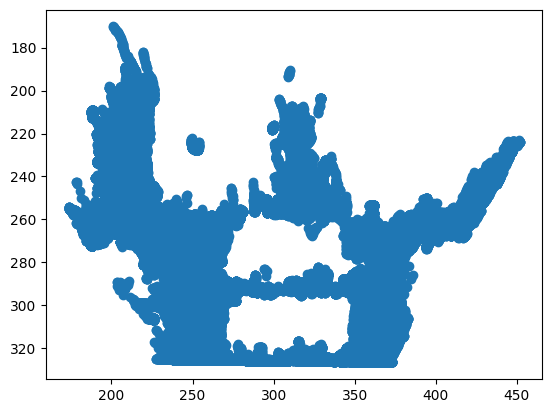

In [36]:
plt.scatter(x*w,y*h)
plt.gca().invert_yaxis()

In [37]:
from scipy.ndimage import gaussian_filter

In [47]:
heatmap, xedges, yedges = np.histogram2d(x_pix, y_pix, bins=200, range=[[0, w], [0, h]])
density = gaussian_filter(heatmap, sigma=3)  # ปรับ sigma ให้เหมาะสม

In [48]:
print("Density shape:", density.shape)

Density shape: (200, 200)


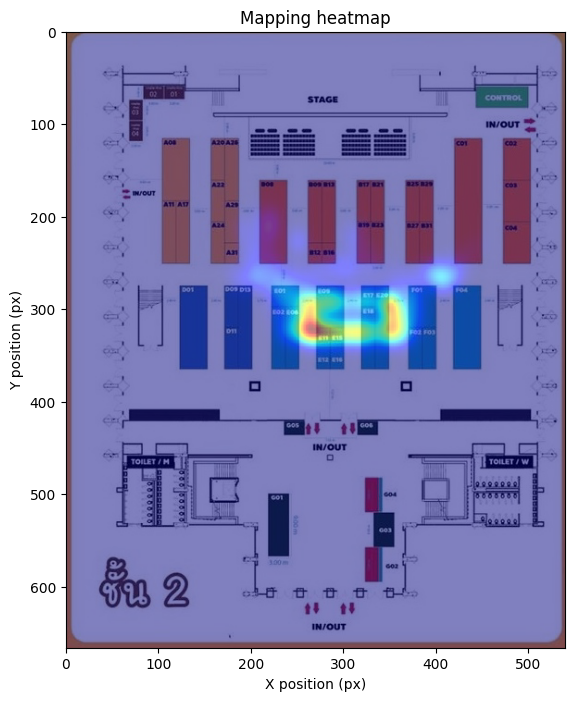

In [49]:
# ===== 4. แสดงภาพ =====
plt.figure(figsize=(12, 8))

# วาดพื้นหลัง
plt.imshow(frame_rgb, extent=[0, w, h, 0])  # extent เพื่อให้ตรงกับพิกัด pixel

# วาด KDE ทับ (โปร่งใส)
plt.imshow(density.T, cmap='jet', extent=[0, w, h, 0], alpha=0.5, origin='upper')

# # วาดจุด scatter (เพื่อเทียบ)
# plt.scatter(x_pix, y_pix, c='white', s=5, alpha=0.6)

plt.title("Mapping heatmap")
plt.xlabel("X position (px)")
plt.ylabel("Y position (px)")
plt.show()

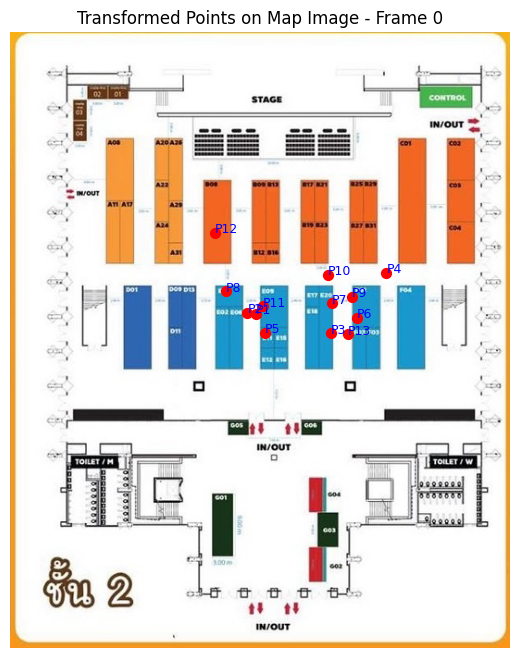

In [46]:
map_h, map_w = map_image.shape[:2]

# กรองเฉพาะ frame_id = 0
df_frame0 = df_interp[df_interp["frame_id"] == 0].copy()

# แปลง string -> list
df_frame0["transformed_point"] = df_frame0["transformed_point"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# แยกพิกัดและแปลงเป็น pixel
xs = [pt[0] * map_w for pt in df_frame0["transformed_point"]]
ys = [pt[1] * map_h for pt in df_frame0["transformed_point"]]

# วาดลงบนภาพ
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB))
plt.scatter(xs, ys, color="red", s=50)

# ใส่ label จุด
for i, (x, y) in enumerate(zip(xs, ys)):
    plt.text(x, y, f"P{i+1}", color="blue", fontsize=9)

plt.title("Transformed Points on Map Image - Frame 0")
plt.axis("off")
plt.show()

In [32]:
# # วนลูปตามแต่ละ frame_id
# for frame in df_interp['frame_id'].unique():
#     df_frame = df_interp[df_interp['frame_id'] == frame]
    
#     x = df_frame['x_pix'].values
#     y = df_frame['y_pix'].values
    
#     # สร้าง 2D histogram
#     heatmap, xedges, yedges = np.histogram2d(x, y, bins=200, range=[[0, w], [0, h]])
    
#     # ทำ smoothing ด้วย gaussian filter
#     density = gaussian_filter(heatmap, sigma=3)
    
#     # (ถ้าต้องการแสดง heatmap แต่ละเฟรม)
#     # วาดพื้นหลัง
#     plt.imshow(frame_rgb, extent=[0, w, h, 0])  # extent เพื่อให้ตรงกับพิกัด pixel

#     # วาด KDE ทับ (โปร่งใส)
#     plt.imshow(density.T, cmap='jet', extent=[0, w, h, 0], alpha=0.5, origin='upper')

#     plt.title("Mapping heatmap")
#     plt.xlabel("X position (px)")
#     plt.ylabel("Y position (px)")
#     plt.show()

In [33]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

In [ ]:
fps = 30  # กำหนด fps ของวิดีโอ
video_filename = "output_heatmap.mp4"

# สร้าง VideoWriter ของ OpenCV
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(video_filename, fourcc, fps, (w, h))

for frame in df_interp['frame_id'].unique():
    df_frame = df_interp[df_interp['frame_id'] == frame]
    
    x = df_frame['x_pix'].values
    y = df_frame['y_pix'].values
    
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=200, range=[[0, w], [0, h]])
    density = gaussian_filter(heatmap, sigma=3)
    
    # สร้างภาพ heatmap ด้วย matplotlib (แต่ไม่แสดงบนจอ)
    fig, ax = plt.subplots(figsize=(w/100, h/100), dpi=100)
    
    # วาดภาพพื้นหลัง
    ax.imshow(frame_rgb, extent=[0, w, h, 0])
    
    # วาด heatmap ทับ (โปร่งใส)
    ax.imshow(density.T, cmap='jet', alpha=0.5, extent=[0, w, h, 0], origin='upper')
    
    ax.axis('off')  # ไม่แสดงแกน
    plt.tight_layout(pad=0)
    
    # บันทึกภาพ matplotlib เป็น numpy array
    fig.canvas.draw()
    img_np = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img_np = img_np.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    
    # แปลง RGB (matplotlib) -> BGR (OpenCV)
    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    
    # เขียนเฟรมลงวิดีโอ
    video_writer.write(img_bgr)

# ปิดไฟล์วิดีโอ
video_writer.release()
print(f"Saved video to {video_filename}")
